In [97]:
from azure.ai.documentintelligence import DocumentIntelligenceClient
from azure.ai.documentintelligence.models import AnalyzeDocumentRequest
from azure.ai.formrecognizer import DocumentAnalysisClient
from azure.core.credentials import AzureKeyCredential
import os 
import glob 
from dotenv import load_dotenv
import pickle 
import pandas as pd
import numpy as np
import openai
import fitz 
import io 
from PIL import Image 
import matplotlib.pyplot as plt 
import base64

load_dotenv()

# with DocumentAnalysisClient(os.getenv('DI_ENDPOINT'), AzureKeyCredential(os.getenv('DI_API_KEY'))) as client:
    
#     with open('28y2.pdf', 'rb') as f:
#         poller = client.begin_analyze_document(
#             "prebuilt-layout", document=f, 
#         )
#     result = poller.result()

# with open('28y2_ocr_result.pkl', 'wb') as f:
#     pickle.dump(result, f)

result = pickle.load(open('28y2_ocr_result.pkl', 'rb'))

openai_client = openai.OpenAI(api_key=os.getenv('OPENAI_API_KEY')) 

In [92]:
pdf = fitz.open('28y2.pdf', )
pix = list(pdf.pages())[0].get_pixmap(dpi=250)
# PILで画像を開く
img = Image.open(io.BytesIO(pix.tobytes('png')))
# 画像をnumpy配列に変換
img = np.array(img)
height, width = img.shape[:2]
height, width

(2125, 2750)

In [93]:
pdf_width = result.pages[0].width
pdf_height = result.pages[0].height

In [94]:
def get_bbox(polygon, pdf_width: float, pdf_height: float, width: int, height: int):
    x_min = min([p.x for p in polygon])
    x_max = max([p.x for p in polygon])
    y_min = min([p.y for p in polygon])
    y_max = max([p.y for p in polygon])
    
    x_min = (x_min * width) / pdf_width
    x_max = (x_max * width) / pdf_width
    y_min = (y_min * height) / pdf_height
    y_max = (y_max * height) / pdf_height
    
    return (int(x_min), int(y_min)), (int(x_max), int(y_max))



max_table = None
max_area = -1000 

for table in result.tables:
    polygon = table.bounding_regions[0].polygon
    x_min = min([p.x for p in polygon])
    x_max = max([p.x for p in polygon])
    y_min = min([p.y for p in polygon])
    y_max = max([p.y for p in polygon])
    
    area = (x_max - x_min) * (y_max - y_min) 
    
    if max_area < area:
        max_area = area 
        max_table = table

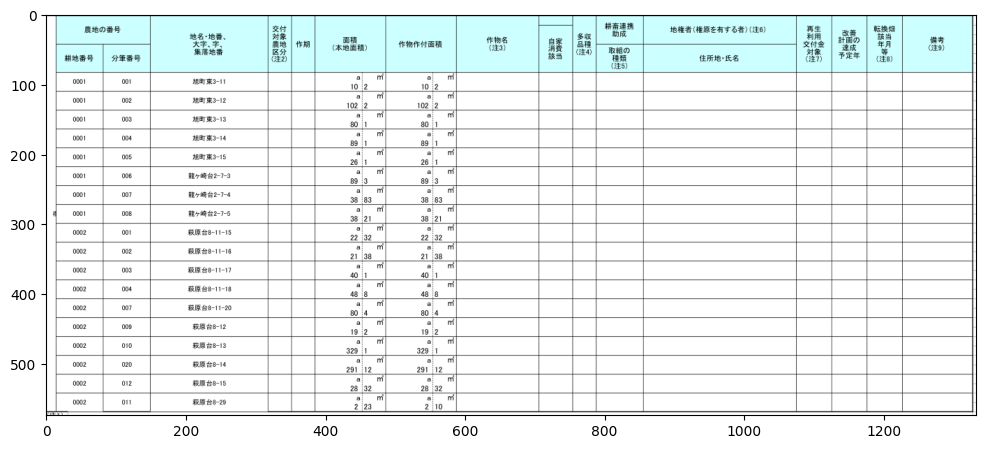

In [95]:
left_top, right_bottom = get_bbox(max_table.bounding_regions[0].polygon, pdf_width, pdf_height, width, height)
cropped_img = img[left_top[1]:right_bottom[1], left_top[0]:right_bottom[0]]
plt.figure(figsize=(12, 8))
plt.imshow(cropped_img)
plt.show()



In [38]:
df = pd.DataFrame(columns=range(max_table.column_count), index=range(max_table.row_count))
for cell in max_table.cells:
    row_index = cell.row_index
    column_index = cell.column_index 
    row_span = cell.row_span 
    c_span = cell.column_span 
    
    if (c_span == 1) and (row_span == 1):
        df.iloc[row_index, column_index] = cell.content
    else:
        for c_ind in range(c_span):
            for r_ind in range(row_span):
                df.iloc[row_index+r_ind, column_index+c_ind] = cell.content 

df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,,農地の番号,農地の番号,地名·地番、 大字、字、 集落地番,文対農区 付象地分。,作期,面積 (本地面積),面積 (本地面積),作物作付面積,作物作付面積,作物名 (注3),消費,多山 品调 (注4),耕畜連携,地権者(権原を有する者)(注6),再生 利用 交付金 対象 (注7),改善 計回の 予定年,転換妇 金日 (注8),49),
1,,耕地番号,分筆番号,地名·地番、 大字、字、 集落地番,文対農区 付象地分。,作期,面積 (本地面積),面積 (本地面積),作物作付面積,作物作付面積,作物名 (注3),消費,多山 品调 (注4),取組の 種類 (注5),住所地·氏名,再生 利用 交付金 対象 (注7),改善 計回の 予定年,転換妇 金日 (注8),49),
2,,0001,001,旭町東3-11,,,ａ\n10,㎡\n2,ａ\n10,㎡\n2,,,,,,,,,,
3,,0001,002,旭町東3-12,,,ａ\n102,㎡\n:2,ａ\n102,㎡\n2,,,,,,,,,,
4,,0001,003,旭町東3-13,,,ａ\n80,㎡\n:1,ａ\n80,㎡\n:1,,,,,,,,,,
5,,0001,004,旭町東3-14,,,ａ\n89,㎡\n1,ａ\n89,㎡\n1,,,,,,,,,,
6,,0001,005,旭町東3-15,,,ａ\n26,ml\n:1,ａ\n26,㎡\n:1,,,,,,,,,,
7,,0001,006,龍ヶ崎台2-7-3,,,ａ\n89,三.\n:3,ａ\n89,㎡\n3,,,,,,,,,,
8,,0001,007,龍ヶ崎台2-7-4,,,ａ\n38,㎡\n:83,ａ\n38,㎡\n83,,,,,,,,,,
9,場,0001,008,龍ヶ崎台2-7-5,,,ａ\n38,㎡\n:21,ａ\n8,ml\n:21,,,,,,,,,,


## OpenAI

In [98]:
def img_to_b64(img: np.ndarray) -> str:
    buffered = io.BytesIO()
    Image.fromarray(img, 'RGB').save(buffered, format='PNG')
    img_str = base64.b64encode(buffered.getvalue()).decode("utf-8")  # Base64にエンコード
    return f"data:image/png;base64,{img_str}"

from pydantic import BaseModel, Field
from typing import Literal

class Row(BaseModel):
    """
    表から取り出した1つの行を入れてください。
    項目は、耕地番号、分筆番号、地番地名、面積です。
    面積は、本地面積を入れてください。
    """
    agri_number: str = Field(..., description='表から抽出した耕地面積を入れる。例: 0001')
    document_number: str = Field(... ,description="表から抽出した文弼番号を入れる。 例: 001")
    addresss: str = Field(..., description="表から抽出した地番地名を入れる. 例: 敷津東10000-20")
    area: float = Field(..., description="表から抽出した本地面積を入れる。面積の単位は、a(アール)で書かれている場合は、平方メートル(m^2)に直して、入れてください。例: 20.0")

class ExctractedTable(BaseModel):
    rows: list[Row]
    area_unit: Literal['a', 'm2']
    
model_name = 'gpt-4o-2024-08-06' 

In [101]:
prompt = f""" 
以下にOCRで抽出した表を載せます。ただ、OCRの結果のため、抽出した文字や値が間違っていることがあります。
あなたのタスクは、この表と画像が一致しているかを判断して、ちゃんとした値を抽出することです。

# 抽出した表
{df.to_csv(index=False)}
"""

completion = openai_client.beta.chat.completions.parse(
    model=model_name,
    messages=[
        {"role": "user", "content": [
            {
                "type": "text", "text": prompt,
            },
            {
                "type": "image_url",
                "image_url": {"url": img_to_b64(img)}
            }
        ]}
    ],
    response_format=ExctractedTable,
)

In [105]:
extracted_table = completion.choices[0].message.parsed
extracted_table.model_dump()

{'rows': [{'agri_number': '0001',
   'document_number': '001',
   'addresss': '旭町東3-11',
   'area': 1000.0},
  {'agri_number': '0001',
   'document_number': '002',
   'addresss': '旭町東3-12',
   'area': 1020.0},
  {'agri_number': '0001',
   'document_number': '003',
   'addresss': '旭町東3-13',
   'area': 800.0},
  {'agri_number': '0001',
   'document_number': '004',
   'addresss': '旭町東3-14',
   'area': 890.0},
  {'agri_number': '0001',
   'document_number': '005',
   'addresss': '旭町東3-15',
   'area': 260.0},
  {'agri_number': '0001',
   'document_number': '006',
   'addresss': '龍ヶ崎台2-7-3',
   'area': 890.0},
  {'agri_number': '0001',
   'document_number': '007',
   'addresss': '龍ヶ崎台2-7-4',
   'area': 380.0},
  {'agri_number': '0001',
   'document_number': '008',
   'addresss': '龍ヶ崎台2-7-5',
   'area': 380.0},
  {'agri_number': '0002',
   'document_number': '001',
   'addresss': '萩原台8-11-15',
   'area': 220.0},
  {'agri_number': '0002',
   'document_number': '002',
   'addresss': '萩原台8-11-16

In [109]:
pd.DataFrame.from_dict(extracted_table.model_dump()['rows'])

,agri_number,document_number,addresss,area
0,0001,001,旭町東3-11,1000.0
1,0001,002,旭町東3-12,1020.0
2,0001,003,旭町東3-13,800.0
3,0001,004,旭町東3-14,890.0
4,0001,005,旭町東3-15,260.0
5,0001,006,龍ヶ崎台2-7-3,890.0
6,0001,007,龍ヶ崎台2-7-4,380.0
7,0001,008,龍ヶ崎台2-7-5,380.0
8,0002,001,萩原台8-11-15,220.0
9,0002,002,萩原台8-11-16,210.0
